In [1]:
import numpy as np
import scipy.linalg
import keras.backend as K
import tensorflow as tf
import sklearn.manifold
import sklearn.metrics

import Diffusion as df
import os.path
from autoencoder import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from keras.utils import np_utils
from keras.layers import Dense, Input
from keras.models import Model
from keras import regularizers

from polynomialcurve import PolynomialPointCurve
import LaplacianEigenmaps

Using TensorFlow backend.
/home/neha/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/neha/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/neha/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/neha/.local/lib/python3.6/site-packages/tensorflow/python/framewo

##  Generate data #######################

The dataset is 2000 random samples from a closed curve in 3D: 

$x_i = \left( \cos(\theta_i), \sin(2\theta_i) , \sin(3\theta_i)\right)^T, \;\;\; \theta_i \in (0,2\pi).    $

In [4]:
n = 3000
t = 2.01*np.pi*np.random.uniform(0,1,n)
x = np.cos(t)
y = np.sin(2*t)
z = np.sin(3*t)
orig_data = np.vstack([x,y,z])
orig_data = np.transpose(orig_data)

# add noise
noise_std = 0.05
data = orig_data + noise_std*np.random.randn(orig_data.shape[0],orig_data.shape[1])

n_train = 2000
n_test = n - n_train

S1_train   = data[:n_train,:]
S1_test    = data[n_train+1:,:]
t_train    = t[:n_train]
t_test     = t[n_train+1:]
input_size = S1_train.shape[1]
batch_size = S1_train.shape[0]

sort_inds = np.argsort(t_train)

In [5]:
print(input_size)

3


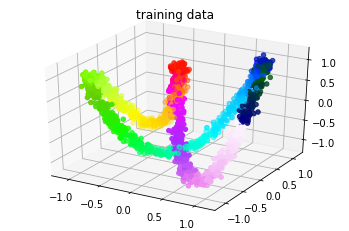

In [6]:
fig, (a1)  = plt.subplots(1,1, subplot_kw={'projection':'3d'})
a1.scatter(S1_train[:,0], S1_train[:,1], S1_train[:,2], c=t_train, cmap='gist_ncar')
plt.title('training data')
plt.show()

The diffusion map of a closed curve is a 2D circle.

In [7]:
nearest_neighbors = 'knn'
k=16
embedding_size = 2
n_paths = 5
hidden_dim  = 40

In [8]:
Idx, Dx = df.Knnsearch(S1_train, S1_train, k)
print(Dx.shape)
K_mat = df.ComputeLBAffinity(Idx, Dx, sig=0.1)  # Laplace-Beltrami affinity: D^-1 * K * D^-1
P = df.makeRowStoch(K_mat)  # markov matrix
E, v = df.Diffusion(K_mat, nEigenVals=embedding_size + 1)  # eigenvalues and eigenvectors
embedding_matrix = P

(2000, 16)


In [9]:
E.shape

(2000, 2)

In [10]:
diffusion_weights =  [tf.cast(tf.constant(np.power(v, i+1)), tf.float32) for i in range(n_paths)]
E_casted = tf.cast(tf.constant(E), tf.float32)

In [11]:
summed = diffusion_weights[0]
for i in range(n_paths -1):
    summed = summed + diffusion_weights[1]
print(summed)

def sum_list_of_tensors(lst, length):
    summed = lst[0]
    for i in range(length - 1):
        summed = summed + diffusion_weights[i+1]
    return summed

Tensor("add_3:0", shape=(2,), dtype=float32)


In [12]:
E_W1 = tf.Variable(tf.random_normal([input_size, hidden_dim]))
E_b1 = tf.Variable(tf.random_normal([hidden_dim]))
E_W2 = tf.Variable(tf.random_normal([hidden_dim, 1]))
E_b2 = tf.Variable(tf.random_normal([1]))
E_W3 = tf.Variable(tf.random_normal([n_paths, batch_size]))
D_W1 = tf.Variable(tf.random_normal([embedding_size, hidden_dim]))
D_b1 = tf.Variable(tf.random_normal([hidden_dim]))
D_W2 = tf.Variable(tf.random_normal([hidden_dim, input_size]))

## 

In [88]:
def neha_autoencoder(x):
    h1 = tf.nn.sigmoid(tf.matmul(x, E_W1) + E_b1)
    h2 = tf.nn.sigmoid(tf.matmul(h1, E_W2) + E_b2)
    alphas = tf.matmul(tf.abs(E_W3), tf.abs(h2))
    weighted_vals = [tf.multiply(alphas[i], diffusion_weights[i]) for i in range(n_paths)]
    total_weighting = sum_list_of_tensors(weighted_vals, n_paths)
    diag_weight = tf.diag(total_weighting)
    emb = tf.matmul(E_casted, diag_weight)
    d1 = tf.nn.sigmoid(tf.matmul(emb, D_W1) + D_b1)
    out = tf.matmul(d1, D_W2)
    return out, alphas

In [89]:
reg_par = 1e-4
learning_rate = 1e-2
n_iters = 12000
parameters = [E_W1, E_W2, E_W3, D_W1, D_W2, E_b1, E_b2, D_b1]
X = tf.placeholder(tf.float32, shape=[batch_size, input_size])
R, A = neha_autoencoder(X)

In [90]:
a_reg = tf.nn.l2_loss(D_W2)
a_loss = tf.reduce_mean(tf.square(X - R)) + reg_par * a_reg
solver = (tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(a_loss, var_list=parameters))
sess = tf.Session()
sess.run(tf.global_variables_initializer())

step 0, loss 6.32e+00
[[1562.186 ]
 [1530.6934]
 [1509.1243]
 [1555.3372]
 [1567.9111]]


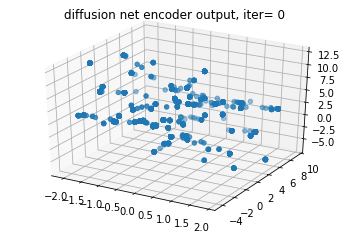

step 1500, loss 8.06e-02
[[0.24166824]
 [0.48189336]
 [0.4750718 ]
 [0.49402604]
 [0.48842144]]


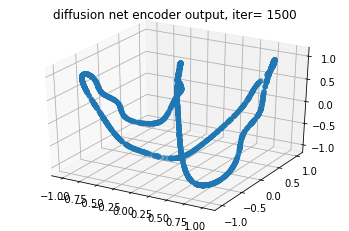

step 3000, loss 7.30e-02
[[0.744326 ]
 [1.410815 ]
 [1.3888872]
 [1.4429107]
 [1.4320455]]


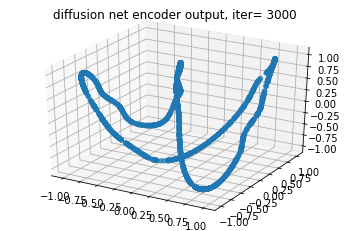

step 4500, loss 6.83e-02
[[1.6674558]
 [3.04027  ]
 [2.9911432]
 [3.1053143]
 [3.0883307]]


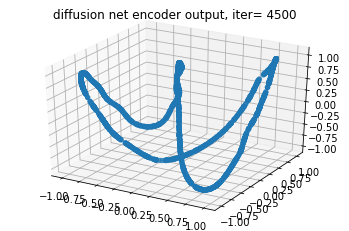

step 6000, loss 6.62e-02
[[2.5582218]
 [4.4598327]
 [4.393609 ]
 [4.5650396]
 [4.522256 ]]


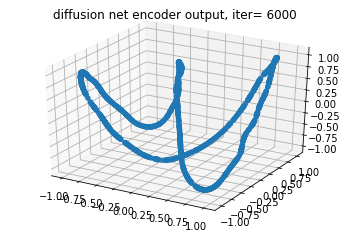

step 7500, loss 6.55e-02
[[3.7330842]
 [6.2135315]
 [6.1329207]
 [6.3740535]
 [6.289057 ]]


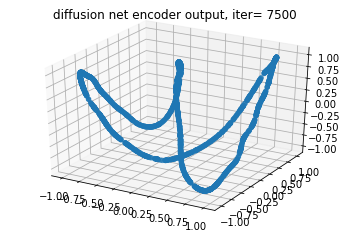

step 9000, loss 6.45e-02
[[5.7563972]
 [9.168743 ]
 [9.064868 ]
 [9.420137 ]
 [9.266607 ]]


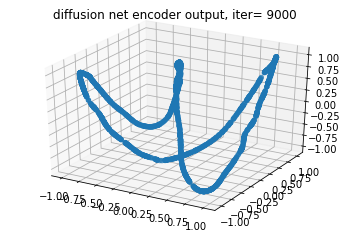

step 10500, loss 6.39e-02
[[ 7.423547]
 [11.260988]
 [11.165665]
 [11.596722]
 [11.355592]]


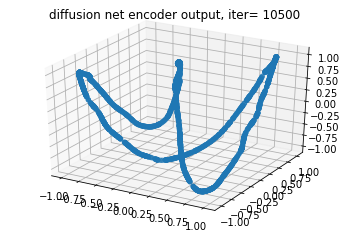

step 12000, loss 6.42e-02
[[ 9.835797 ]
 [14.298138 ]
 [14.208427 ]
 [14.744272 ]
 [14.3949175]]


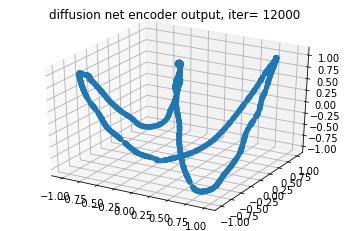

In [91]:
for i in range(n_iters+1):
    if i % 1500 == 0:  # plot intermediate outputs
        r, al = sess.run((R,A), feed_dict={X: S1_train})
        loss = np.mean(np.sum(np.abs(S1_train - r) ** 2, axis=1) ** (1. / 2))
        print('step %.d, loss %.2e' % (i, loss))
        print(al)
        fig, (a2) = plt.subplots(1, 1, subplot_kw={'projection': '3d'})
        a2.scatter(r[:, 0], r[:, 1], r[:,2])
        plt.axis('auto')
        plt.title('diffusion net encoder output, iter= ' + str(i))
        plt.show()
    _ = sess.run(solver, feed_dict={X:S1_train})
        
    

In [78]:
sess.close()